In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

import bayesflow as bf
from bayesflow.amortizers import AmortizedPointEstimator
from bayesflow.benchmarks import Benchmark
from bayesflow.helper_networks import ConfigurableMLP
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.summary_networks import DeepSet

np.random.seed(2024)


/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:

def batch_prior_fun(batch_size):
    # InverseGamma(alpha, beta)
    alpha, beta = 2.0, 1.0 
    dist = tfp.distributions.InverseGamma(concentration=alpha, scale=beta)
    return dist.sample((batch_size, 1))

# 定义模拟器
def batch_simulator_fun(gamma, n_obs=1000, mu=0):
    return tf.random.normal((gamma.shape[0], n_obs), mean=mu, stddev=tf.sqrt(gamma))[:, :, None]


In [3]:
from bayesflow.amortizers import AmortizedPointEstimator
from bayesflow.helper_networks import ConfigurableMLP

prior = Prior(batch_prior_fun=batch_prior_fun)
simulator = Simulator(batch_simulator_fun=batch_simulator_fun)
generative_model = GenerativeModel(prior=prior, simulator=simulator)

summary_dim = 10
summary_net = DeepSet(summary_dim)

inference_net = ConfigurableMLP(input_dim=summary_dim, output_dim=1, dropout_rate=0.1)

amortizer = AmortizedPointEstimator(inference_net, summary_net=summary_net, norm_ord=1)


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [4]:
# 定义配置器
def config(forward_dict):
    """Helper function for posterior configuration."""
    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"]
    input_dict["summary_conditions"] = forward_dict["sim_data"]
    return input_dict

#Trainer
from bayesflow.trainers import Trainer
trainer = Trainer(
    amortizer=amortizer,
    configurator=config,
    generative_model=generative_model
)

h = trainer.train_online(1, 500, batch_size=32)


INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
Training epoch 1: 100%|██████████| 500/500 [00:25<00:00, 19.91it/s, Epoch: 1, Iter: 500,Loss: 0.049,Avg.Loss: 0.128,LR: 4.93E-09]


In [5]:
#get test data
num_test = 1000
test_param_fun = lambda batch_size: tf.ones((batch_size, 1)) * 0.3  # sigma^2 = 0.3 for all simulations
test_model = GenerativeModel(prior=Prior(batch_prior_fun=test_param_fun), simulator=simulator)
test_data = config(test_model(num_test))

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [6]:
# inference gamma
estimates = amortizer.estimate(test_data)[:, 0]
summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])
summary_conditions.shape

TensorShape([1000, 1])

In [7]:
def bayes_estimator(Z, mu_0=0, alpha_0=2, beta_0=1):
    """
    Implements a Bayesian estimator, calculates the posterior distribution 
    based on the prior and observed data, and samples from it.
    
    Parameters:
    - Z: Input data, shape TensorShape([n, 1]).
    - mu_0: Prior mean.
    - alpha_0: Initial shape parameter of the Inverse-Gamma distribution.
    - beta_0: Initial scale parameter of the Inverse-Gamma distribution.
    
    Returns:
    - posterior_samples: 1000 samples drawn from the posterior distribution.
    """
    # Ensure Z is a TensorFlow tensor
    Z = tf.convert_to_tensor(Z, dtype=tf.float32)

    # Compute the mean (y_bar) and the number of observations (n)
    y_bar = tf.reduce_mean(Z)  # Sample mean
    n = tf.cast(Z.shape[0], tf.float32)  # Sample size

    # Compute the sum of squared differences from y_bar
    variance = tf.reduce_sum(tf.square(Z - y_bar))  # Sum of squared differences

    # Update the posterior parameters for the Inverse-Gamma distribution
    alpha = alpha_0 + n / 2
    beta = beta_0 + variance / 2 

    # Define the posterior distribution
    dist = tfp.distributions.InverseGamma(concentration=alpha, scale=beta)

    # Sample from the posterior distribution
    posterior_samples = dist.sample(1000).numpy()
    return posterior_samples

# Reshape the data
# summary_conditions = tf.reshape(test_data["summary_conditions"], [-1, 1])
summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])

# Call bayes_estimator
reference = bayes_estimator(summary_conditions)
# reference = bayes_estimator(test_data["summary_conditions"])


/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_6236/4220323075.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)


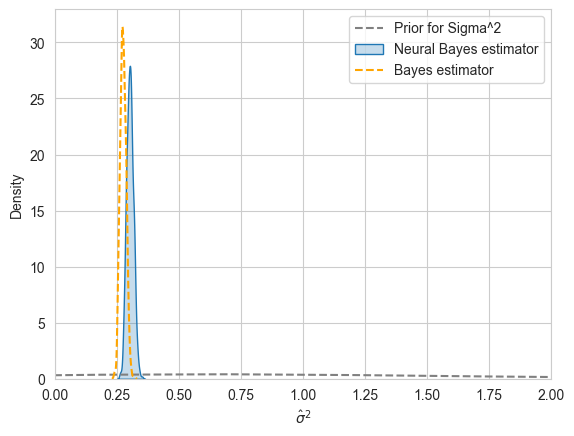

In [8]:
# Define the prior distribution for miu as an Inverse Gamma distribution
prior_dist = tfp.distributions.InverseGamma(2.0, 1.0)

# Sample 1000 points from the distribution
prior_samples = prior_dist.sample(1000).numpy()

# Set the x-axis range
plt.xlim(0, 2)

# Plot the prior distribution
sns.kdeplot(prior_samples, label="Prior for Sigma^2", color="grey", linestyle="--")
sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)
sns.kdeplot(reference, label="Bayes estimator", color="orange", linestyle="--")
plt.xlabel(r"$\hat\sigma^2$")
_ = plt.legend()


/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_6236/2143472740.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)


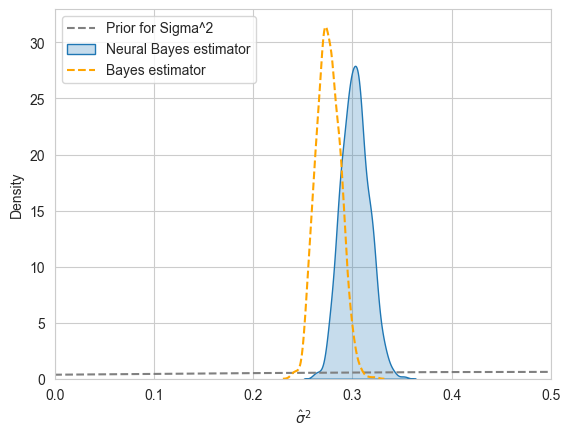

In [9]:
# Define the prior distribution for miu as an Inverse Gamma distribution
prior_dist = tfp.distributions.InverseGamma(2.0, 1.0)

# Sample 1000 points from the distribution
prior_samples = prior_dist.sample(1000).numpy()

# Set the x-axis range
plt.xlim(0, 0.5)

# Plot the prior distribution
sns.kdeplot(prior_samples, label="Prior for Sigma^2", color="grey", linestyle="--")
sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)
sns.kdeplot(reference, label="Bayes estimator", color="orange", linestyle="--")
plt.xlabel(r"$\hat\sigma^2$")
_ = plt.legend()


In [10]:
# Define test data
num_test = 1000
test_param_fun = lambda batch_size: tf.ones((batch_size, 1)) * 1  #  sigma^2 = 1 for all simulations
test_model = GenerativeModel(prior=Prior(batch_prior_fun=test_param_fun), simulator=simulator)
test_data = config(test_model(num_test))

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [11]:
# inference gamma
estimates = amortizer.estimate(test_data)[:, 0]
summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])
summary_conditions.shape

TensorShape([1000, 1])

In [12]:
def bayes_estimator(Z, mu_0=0, alpha_0=2, beta_0=1):
    """
    Implements a Bayesian estimator, calculates the posterior distribution 
    based on the prior and observed data, and samples from it.
    
    Parameters:
    - Z: Input data, shape TensorShape([n, 1]).
    - mu_0: Prior mean.
    - alpha_0: Initial shape parameter of the Inverse-Gamma distribution.
    - beta_0: Initial scale parameter of the Inverse-Gamma distribution.
    
    Returns:
    - posterior_samples: 1000 samples drawn from the posterior distribution.
    """
    # Ensure Z is a TensorFlow tensor
    Z = tf.convert_to_tensor(Z, dtype=tf.float32)

    # Compute the mean (y_bar) and the number of observations (n)
    y_bar = tf.reduce_mean(Z)  # Sample mean
    n = tf.cast(Z.shape[0], tf.float32)  # Sample size

    # Compute the sum of squared differences from y_bar
    variance = tf.reduce_sum(tf.square(Z - y_bar))  # Sum of squared differences

    # Update the posterior parameters for the Inverse-Gamma distribution
    alpha = alpha_0 + n / 2
    beta = beta_0 + variance / 2 

    # Define the posterior distribution
    dist = tfp.distributions.InverseGamma(concentration=alpha, scale=beta)

    # Sample from the posterior distribution
    posterior_samples = dist.sample(1000).numpy()
    return posterior_samples

# Reshape the data
# summary_conditions = tf.reshape(test_data["summary_conditions"], [-1, 1])
summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])

# Call bayes_estimator
reference = bayes_estimator(summary_conditions)
# reference = bayes_estimator(test_data["summary_conditions"])


/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_6236/4220323075.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)


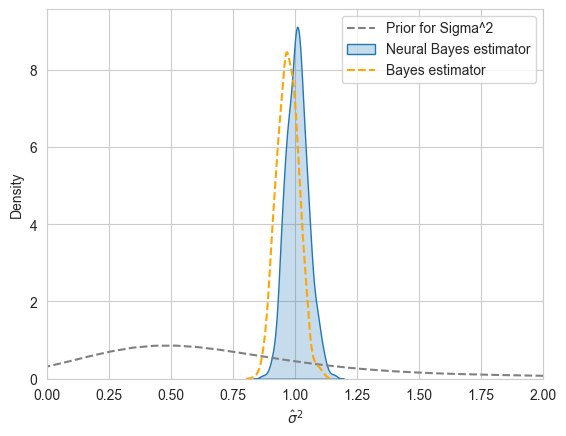

In [13]:
# Define the prior distribution for miu as an Inverse Gamma distribution
prior_dist = tfp.distributions.InverseGamma(2.0, 1.0)

# Sample 1000 points from the distribution
prior_samples = prior_dist.sample(1000).numpy()

# Set the x-axis range
plt.xlim(0, 2)

# Plot the prior distribution
sns.kdeplot(prior_samples, label="Prior for Sigma^2", color="grey", linestyle="--")
sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)
sns.kdeplot(reference, label="Bayes estimator", color="orange", linestyle="--")
plt.xlabel(r"$\hat\sigma^2$")
_ = plt.legend()
